## Introduction

This kernels uses the recent pip wheel of DALI for decoding dicoms using GPU. It works for all JPEG2000 and most of the JPEG-lossless formated images.

The decoding work strongly is based on the kernels of Theo Viel (@theoviel) and David Austin (@tivfrvqhs5)

***WARNING***: Allthough the GPU decoding works for all train images, a few of the JPEG-lossless formated DICOMS (TransferSyntaxUID == '1.2.840.10008.1.2.4.70') of the hidden test set cannot be decoded. So its crucial to have a CPU fallback in place so the notebook wont throw an exception in the submission re-run

## Requirements

We start with installing pip requirements.

In [1]:
!pip install -q timm==0.6.5 --no-index --find-links=/kaggle/input/rsna-bc-pip-requirements
!pip install -q albumentations==1.2.1 --no-index --find-links=/kaggle/input/rsna-bc-pip-requirements
!pip install -q pylibjpeg-libjpeg==1.3.1 --no-index --find-links=/kaggle/input/rsna-bc-pip-requirements
# !pip install -q pydicom==2.0.0 --no-index --find-links=/kaggle/input/rsna-bc-pip-requirements
!pip install -q python-gdcm==3.0.20 --no-index --find-links=/kaggle/input/rsna-bc-pip-requirements
!pip install -q dicomsdl==0.109.1 --no-index --find-links=/kaggle/input/rsna-bc-pip-requirements

Then we install the latest DALI packaging which we will use for GPU decoding

In [2]:
!pip install -q /kaggle/input/nvidia-dali-nightly-cuda110-1230dev/nvidia_dali_nightly_cuda110-1.23.0.dev20230203-7187866-py3-none-manylinux2014_x86_64.whl

In [3]:
# Install Keras CV Attention Model Pip Package for ConvNextV2 Models
!pip install --no-deps /kaggle/input/keras-cv-attention-models/keras_cv_attention_models-1.3.9-py3-none-any.whl

Processing /kaggle/input/keras-cv-attention-models/keras_cv_attention_models-1.3.9-py3-none-any.whl


Next, we import all the packages we need and patch a function to allow for INT16 support

In [4]:
import timm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from copy import copy
import gc
import shutil 

import glob
from scipy.special import expit

import albumentations as A
import cv2
cv2.setNumThreads(0)

import dicomsdl
import pydicom
from pydicom.filebase import DicomBytesIO

from os.path import join

from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing as mp

from types import SimpleNamespace
from typing import Any, Dict

import tensorflow as tf


import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali import pipeline_def
from nvidia.dali.types import DALIDataType

In [5]:
#we need to patch DALI for Int16 support


from nvidia.dali.backend import TensorGPU, TensorListGPU
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
from nvidia.dali import types
from nvidia.dali.plugin.base_iterator import _DaliBaseIterator
from nvidia.dali.plugin.base_iterator import LastBatchPolicy
import torch
import torch.utils.dlpack as torch_dlpack
import ctypes
import numpy as np
import torch.nn.functional as F
import pydicom

to_torch_type = {
    types.DALIDataType.FLOAT:   torch.float32,
    types.DALIDataType.FLOAT64: torch.float64,
    types.DALIDataType.FLOAT16: torch.float16,
    types.DALIDataType.UINT8:   torch.uint8,
    types.DALIDataType.INT8:    torch.int8,
    types.DALIDataType.UINT16:  torch.int16,
    types.DALIDataType.INT16:   torch.int16,
    types.DALIDataType.INT32:   torch.int32,
    types.DALIDataType.INT64:   torch.int64
}


def feed_ndarray(dali_tensor, arr, cuda_stream=None):
    """
    Copy contents of DALI tensor to PyTorch's Tensor.

    Parameters
    ----------
    `dali_tensor` : nvidia.dali.backend.TensorCPU or nvidia.dali.backend.TensorGPU
                    Tensor from which to copy
    `arr` : torch.Tensor
            Destination of the copy
    `cuda_stream` : torch.cuda.Stream, cudaStream_t or any value that can be cast to cudaStream_t.
                    CUDA stream to be used for the copy
                    (if not provided, an internal user stream will be selected)
                    In most cases, using pytorch's current stream is expected (for example,
                    if we are copying to a tensor allocated with torch.zeros(...))
    """
    dali_type = to_torch_type[dali_tensor.dtype]

    assert dali_type == arr.dtype, ("The element type of DALI Tensor/TensorList"
                                    " doesn't match the element type of the target PyTorch Tensor: "
                                    "{} vs {}".format(dali_type, arr.dtype))
    assert dali_tensor.shape() == list(arr.size()), \
        ("Shapes do not match: DALI tensor has size {0}, but PyTorch Tensor has size {1}".
            format(dali_tensor.shape(), list(arr.size())))
    cuda_stream = types._raw_cuda_stream(cuda_stream)

    # turn raw int to a c void pointer
    c_type_pointer = ctypes.c_void_p(arr.data_ptr())
    if isinstance(dali_tensor, (TensorGPU, TensorListGPU)):
        stream = None if cuda_stream is None else ctypes.c_void_p(cuda_stream)
        dali_tensor.copy_to_external(c_type_pointer, stream, non_blocking=True)
    else:
        dali_tensor.copy_to_external(c_type_pointer)
    return arr





Next I set major variables which handle the public run and the re-run on the hidden test set, and also allow for simulating the size of the hidden test set by setting RAM_CHECK = True

In [6]:
# Params

COMP_FOLDER = '/kaggle/input/rsna-breast-cancer-detection/'
DATA_FOLDER = COMP_FOLDER + 'test_images/'

sample_submission = pd.read_csv(COMP_FOLDER + 'sample_submission.csv')

PUBLIC_RUN = len(sample_submission) == 2

N_CORES = mp.cpu_count()
MIXED_PRECISION = False
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

RAM_CHECK = False
DEBUG = False

test_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
test_df['cancer'] = 0 #dummy value


if PUBLIC_RUN is False:
    RAM_CHECK = False
    DEBUG = False

if RAM_CHECK is True:
    test_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')[:50]
    
    test_df = test_df[test_df.image_id!=1942326353].reset_index(drop=True)
    print(test_df.shape)
    
    patient_filter = list(sorted((set(test_df.patient_id.unique()))))
    test_df = test_df[test_df.patient_id.isin(patient_filter)]
    DATA_FOLDER = DATA_FOLDER.replace('test','train')

if DEBUG is True:
    test_df = test_df.head(500)

test_df

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer
0,2,10008,736471439,L,MLO,81,0,21,10008_L,0
1,2,10008,1591370361,L,CC,81,0,21,10008_L,0
2,2,10008,68070693,R,MLO,81,0,21,10008_R,0
3,2,10008,361203119,R,CC,81,0,21,10008_R,0


In [7]:
print(f'Len df : {len(test_df)}')
test_df['patient_id'].nunique()

Len df : 4


1

In [8]:
test_df["fns"] = test_df['patient_id'].astype(str) + '/' + test_df['image_id'].astype(str) + '.dcm'

Next, we define the function for GPU-based decoding using DALI and processing the dicom images

In [9]:
def convert_dicom_to_jpg(file, save_folder=""):
    patient = file.split('/')[-2]
    image = file.split('/')[-1][:-4]
    dcmfile = pydicom.dcmread(file)

    if dcmfile.file_meta.TransferSyntaxUID == '1.2.840.10008.1.2.4.90':
        with open(file, 'rb') as fp:
            raw = DicomBytesIO(fp.read())
            ds = pydicom.dcmread(raw)
        offset = ds.PixelData.find(b"\x00\x00\x00\x0C")  #<---- the jpeg2000 header info we're looking for
        hackedbitstream = bytearray()
        hackedbitstream.extend(ds.PixelData[offset:])
        with open(save_folder + f"{patient}_{image}.jpg", "wb") as binary_file:
            binary_file.write(hackedbitstream)
            
    if dcmfile.file_meta.TransferSyntaxUID == '1.2.840.10008.1.2.4.70':
        with open(file, 'rb') as fp:
            raw = DicomBytesIO(fp.read())
            ds = pydicom.dcmread(raw)
        offset = ds.PixelData.find(b"\xff\xd8\xff\xe0")  #<---- the jpeg lossless header info we're looking for
        hackedbitstream = bytearray()
        hackedbitstream.extend(ds.PixelData[offset:])
        with open(save_folder + f"{patient}_{image}.jpg", "wb") as binary_file:
            binary_file.write(hackedbitstream)

            
@pipeline_def
def jpg_decode_pipeline(jpgfiles):
    jpegs, _ = fn.readers.file(files=jpgfiles)
    images = fn.experimental.decoders.image(jpegs, device='mixed', output_type=types.ANY_DATA, dtype=DALIDataType.UINT16)
    return images

def parse_window_element(elem):
    if type(elem)==list:
        return float(elem[0])
    if type(elem)==str:
        return float(elem)
    if type(elem)==float:
        return elem
    if type(elem)==pydicom.dataelem.DataElement:
        try:
            return float(elem[0])
        except:
            return float(elem.value)
    return None

def linear_window(data, center, width):
    lower, upper = center - width // 2, center + width // 2
    data = torch.clamp(data, min=lower, max=upper)
    return data 

def process_dicom(img, dicom):
    try:
        invert = getattr(dicom, "PhotometricInterpretation", None) == "MONOCHROME1"
    except:
        invert = False
        
    center = parse_window_element(dicom["WindowCenter"]) 
    width = parse_window_element(dicom["WindowWidth"])
        
    if (center is not None) & (width is not None):
        img = linear_window(img, center, width)

    img = (img - img.min()) / (img.max() - img.min())
    if invert:
        img = 1 - img
    return img

In [10]:
cfg = SimpleNamespace(**{})
cfg.img_size = 1024
cfg.backbone = 'seresnext50_32x4d'
cfg.pretrained=False
cfg.in_channels = 1
cfg.classes = ['cancer']
cfg.batch_size = 8
cfg.data_folder = "/tmp/output/"
cfg.val_aug = A.CenterCrop(always_apply=False, p=1.0, height=cfg.img_size, width=cfg.img_size)
cfg.device = DEVICE

We will process the dicoms in chunks so the disk space does not become an issue. 

In [11]:
SAVE_SIZE = int(cfg.img_size * 1.125)


TARGET_HEIGHT_WIDTH_RATIO = 1

In [12]:
if RAM_CHECK is True:
    SAVE_FOLDER = 'output/'
    JPG_FOLDER = "jpg/"
else:
    SAVE_FOLDER = "/tmp/output/"
    JPG_FOLDER = "/tmp/jpg/"

os.makedirs(JPG_FOLDER, exist_ok=True)
os.makedirs(SAVE_FOLDER, exist_ok=True)
N_CHUNKS = len(test_df["fns"]) // 2000 if len(test_df["fns"]) > 2000 else 1
CHUNKS = [(len(test_df["fns"]) / N_CHUNKS * k, len(test_df["fns"]) / N_CHUNKS * (k + 1)) for k in range(N_CHUNKS)]
CHUNKS = np.array(CHUNKS).astype(int)


In [13]:
for ttt, chunk in enumerate(CHUNKS):
    print(f'chunk {ttt} of {len(CHUNKS)} chunks')
    os.makedirs(JPG_FOLDER, exist_ok=True)

    _ = Parallel(n_jobs=2)(
        delayed(convert_dicom_to_jpg)(f'{DATA_FOLDER}/{img}', save_folder=JPG_FOLDER)
        for img in test_df["fns"].tolist()[chunk[0]: chunk[1]]
    )
    
    jpgfiles = glob.glob(JPG_FOLDER + "*.jpg")


    pipe = jpg_decode_pipeline(jpgfiles, batch_size=1, num_threads=2, device_id=0)
    pipe.build()

    for i, f in enumerate(tqdm(jpgfiles)):
        
        patient, dicom_id = f.split('/')[-1][:-4].split('_')
        dicom = pydicom.dcmread(DATA_FOLDER + f"/{patient}/{dicom_id}.dcm")
        try:
            out = pipe.run()
            # Dali -> Torch
            img = out[0][0]
            img_torch = torch.empty(img.shape(), dtype=torch.int16, device="cuda")
            feed_ndarray(img, img_torch, cuda_stream=torch.cuda.current_stream(device=0))
            img = img_torch.float()

            


            #apply dicom preprocessing
            img = process_dicom(img, dicom)

            #resize the torch image
            img = F.interpolate(img.view(1, 1, img.size(0), img.size(1)), (SAVE_SIZE, SAVE_SIZE), mode="bilinear")[0, 0]

            img = (img * 255).clip(0,255).to(torch.uint8).cpu().numpy()
            out_file_name = SAVE_FOLDER + f"{patient}_{dicom_id}.png"
            cv2.imwrite(out_file_name, img)
    
        except Exception as e:
            print(i, e)
            pipe = jpg_decode_pipeline(jpgfiles[i+1:], batch_size=1, num_threads=2, device_id=0)
            pipe.build()
            continue

    shutil.rmtree(JPG_FOLDER)
print(f'DALI Raw image load complete')

chunk 0 of 1 chunks


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

DALI Raw image load complete


In [14]:
fns = glob.glob(f'{SAVE_FOLDER}/*.png')
n_saved = len(fns)
print(f'Image on disk count : {n_saved}')

Image on disk count : 4


A few hidden test set images might not be decoded via DALI, so we fallback to CPU for those

In [15]:
gpu_processed_files = [fn.split('/')[-1].replace('_','/').replace('png','dcm') for fn in fns]
to_process = [f for f in test_df["fns"].values if f not in gpu_processed_files]
len(gpu_processed_files), len(to_process)

(4, 0)

In [16]:
def process(f, save_folder=""):
    patient = f.split('/')[-2]
    dicom_id = f.split('/')[-1][:-4]
    
    dicom = dicomsdl.open(f)
    img = dicom.pixelData()
    img = torch.from_numpy(img)
    img = process_dicom(img, dicom)
    
    img = F.interpolate(img.view(1, 1, img.size(0), img.size(1)), (SAVE_SIZE, SAVE_SIZE), mode="bilinear")[0, 0]

    img = (img * 255).clip(0,255).to(torch.uint8).cpu().numpy()
    out_file_name = SAVE_FOLDER + f"{patient}_{dicom_id}.png"
    cv2.imwrite(out_file_name, img)
    return out_file_name

In [17]:
cpu_processed_filenames = Parallel(n_jobs=2)(
    delayed(process)(f'{DATA_FOLDER}/{img}', save_folder=SAVE_FOLDER)
    for img in tqdm(to_process)
)
cpu_processed_filenames = [f for f in cpu_processed_filenames if f]
print(f'CPU Raw image load complete with {len(cpu_processed_filenames)} loaded')

0it [00:00, ?it/s]

CPU Raw image load complete with 0 loaded


In [18]:
gc.collect()
torch.cuda.empty_cache()

In [19]:
n_saved = len(glob.glob(f'{SAVE_FOLDER}/*.png'))
print(f'Image on disk count : {n_saved}')

Image on disk count : 4


In [20]:
SAVE_FOLDER

'/tmp/output/'

In [21]:
assert n_saved == len(test_df)

In [22]:
def normalize(image):
    # Repeat channels to create 3 channel images required by pretrained ConvNextV2 models
    image = tf.repeat(image, repeats=3, axis=3)
    # Cast to float 32
    image = tf.cast(image, tf.float32)
    # Normalize with respect to ImageNet mean/std
    image = tf.keras.applications.imagenet_utils.preprocess_input(image, mode='torch')

    return image

In [23]:
def get_model(weightpath):
    # Inputs, note the names are equal to the dictionary keys in the dataset
    image = tf.keras.layers.Input(INPUT_SHAPE, name='image', dtype=tf.uint8)

    # Normalize Input
    image_norm = normalize(image)
    
    # CNN Feature Maps
    x = convnext.ConvNeXtV2Tiny(
        input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3),
        pretrained=None,
        num_classes=0,
    )(image_norm)

    # Average Pooling BxHxWxC -> BxC
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # Dropout to prevent Overfitting
    x = tf.keras.layers.Dropout(0.30)(x)
    # Output value between [0, 1] using Sigmoid function
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Define model with inputs and outputs
    model = tf.keras.models.Model(inputs=image, outputs=outputs)

    # Load pretrained Model Weights
    model.load_weights(weightpath)

    # Set model non-trainable
    model.trainable = False

    # Compile model
    model.compile()

    return model

In [24]:
TARGET_HEIGHT = 1152
TARGET_WIDTH = 1152
N_CHANNELS = 1
INPUT_SHAPE = (TARGET_HEIGHT, TARGET_WIDTH, N_CHANNELS)
TARGET_HEIGHT_WIDTH_RATIO = 1
THRESHOLD_BEST = 0.50

CLAHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))

CROP_IMAGE = True
APPLY_CLAHE = False
APPLY_EQ_HIST = False

IMAGE_FORMAT = 'jpg'

In [25]:
from keras_cv_attention_models import convnext


In [26]:
# Pretrained File Path: '/kaggle/input/sartorius-training-dataset/model.h5'
tf.keras.backend.clear_session()
# enable XLA optmizations
tf.config.optimizer.set_jit(True)

# model = get_model()
modellist = []

for ii in range(5):
    model = get_model(f'/kaggle/input/rsna-convnextv2-training-tpu-final/model_{ii}.h5')
    modellist.append(model)


In [27]:
model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 1152, 1152, 1)]   0         
_________________________________________________________________
tf.repeat_4 (TFOpLambda)     (None, 1152, 1152, None)  0         
_________________________________________________________________
tf.cast_4 (TFOpLambda)       (None, 1152, 1152, None)  0         
_________________________________________________________________
tf.math.truediv_80 (TFOpLamb (None, 1152, 1152, None)  0         
_________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda (None, 1152, 1152, 3)     0         
_________________________________________________________________
tf.math.truediv_81 (TFOpLamb (None, 1152, 1152, 3)     0         
_________________________________________________________________
convnext_v2_tiny (Functional (None, 36, 36, 768)       2786

In [28]:
test = test_df.copy()

def get_file_path(args):
    patient_id, image_id = args
    return f'/kaggle/input/rsna-breast-cancer-detection/test_images/{patient_id}/{image_id}.dcm'
    
test['file_path'] = test[['patient_id', 'image_id']].apply(get_file_path, axis=1)

display(test.info())
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   site_id        4 non-null      int64 
 1   patient_id     4 non-null      int64 
 2   image_id       4 non-null      int64 
 3   laterality     4 non-null      object
 4   view           4 non-null      object
 5   age            4 non-null      int64 
 6   implant        4 non-null      int64 
 7   machine_id     4 non-null      int64 
 8   prediction_id  4 non-null      object
 9   cancer         4 non-null      int64 
 10  fns            4 non-null      object
 11  file_path      4 non-null      object
dtypes: int64(7), object(5)
memory usage: 512.0+ bytes


None

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer,fns,file_path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,0,10008/736471439.dcm,/kaggle/input/rsna-breast-cancer-detection/tes...
1,2,10008,1591370361,L,CC,81,0,21,10008_L,0,10008/1591370361.dcm,/kaggle/input/rsna-breast-cancer-detection/tes...
2,2,10008,68070693,R,MLO,81,0,21,10008_R,0,10008/68070693.dcm,/kaggle/input/rsna-breast-cancer-detection/tes...
3,2,10008,361203119,R,CC,81,0,21,10008_R,0,10008/361203119.dcm,/kaggle/input/rsna-breast-cancer-detection/tes...


In [29]:
sample_submission = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv')

display(sample_submission.info())
display(sample_submission.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   prediction_id  2 non-null      object 
 1   cancer         2 non-null      float64
dtypes: float64(1), object(1)
memory usage: 160.0+ bytes


None

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [30]:
#this is dicom_reader_v3a.p

###########################################################################################
#from pydicom.pixel_data_handlers.util import apply_voi_lut
from typing import (
    Dict, Optional, Union, List, Tuple, TYPE_CHECKING, cast, Iterable,
    ByteString
)
from pydicom.valuerep import VR

# Binarize the image at the threshold
def _binarize(img, threshold):
    return (img > threshold).astype(np.uint8)

# Get contour points of the breast
def _extract_contour(bin_img):
    contours, _ = cv2.findContours(
        bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)
    return contour


# Set to background pixels of the image to zero
def _erase_background(img, contour):
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
    output = cv2.bitwise_and(img, mask)
    return output
    
 # Crop the useless background of the image
def img2roi(img):
    
    # Flip T0 Left/Right Orientation
    h0, w0 = img.shape
    if img[:,int(-w0 * 0.10):].sum() > img[:,:int(w0 * 0.10)].sum():
        img = np.flip(img, axis=1)
        
        
    bin_img = _binarize(img, threshold=5)
    contour = _extract_contour(bin_img)
    img = _erase_background(img, contour)
    x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
    y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
    x1, x2 = int(0.975 * x1), int(1.025 * x2)
    y1, y2 = int(0.975 * y1), int(1.025 * y2)
    
    x_offset = x2#get_x_offset(image, debug=debug)
    offset_bottom, offset_top = y1, y2#get_y_offsets(image[:,:x_offset], debug=debug)
    # Crop Height and Width
    h_crop = offset_top - offset_bottom
    w_crop = x_offset - x1
    
    # Pad crop offsets to target aspect ratio
    # Height too large, pad x offset
    if (h_crop / w_crop) > TARGET_HEIGHT_WIDTH_RATIO:
#         print('add x')
        x_offset += int(h_crop / TARGET_HEIGHT_WIDTH_RATIO - w_crop)
    else:
#         print('add y')
        # Height too small, pad bottom/top offsets
        offset_bottom -= int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
        offset_bottom_correction = max(0, -offset_bottom)
        offset_bottom += offset_bottom_correction

        offset_top += int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
        offset_top += offset_bottom_correction
        
    # Crop Image
#     image = image[offset_bottom:offset_top:,:x_offset]
    
    return img[offset_bottom:offset_top, x1:x_offset]   

In [31]:
# glob.glob(f'{SAVE_FOLDER}/*')

  0%|          | 0/2 [00:00<?, ?it/s]

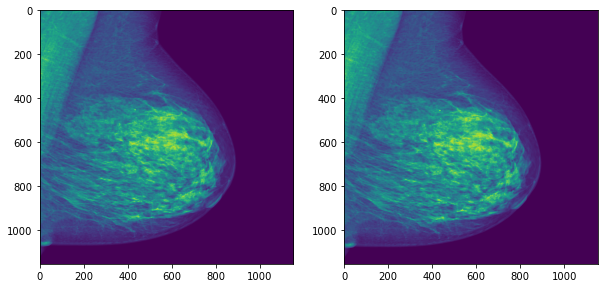

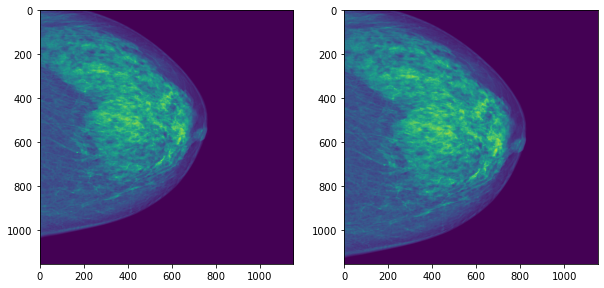

 50%|█████     | 1/2 [00:31<00:31, 31.28s/it]

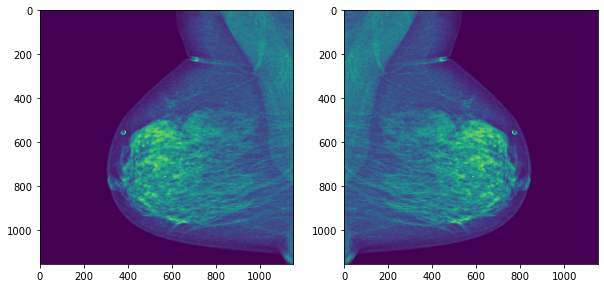

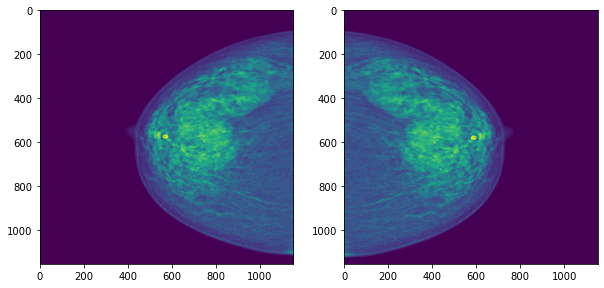

100%|██████████| 2/2 [00:32<00:00, 16.46s/it]


In [32]:
import matplotlib.pyplot as plt
SUBMISSION_ROWS = []
# Iterate over all patient_id/laterality combinations groups
for idx, ((patient_id, laterality), g) in enumerate(tqdm(test.groupby(['patient_id', 'laterality']))):
    # Cancer target is mean of predicted cancer values
    cancer = []#0
    # Iterate over all scans in group
    for row_idx, row in g.iterrows():
        # Load Image
        image_id = row['image_id']
        image = cv2.imread(f'{SAVE_FOLDER}/{patient_id}_{image_id}.png', cv2.IMREAD_GRAYSCALE)
        image_ori = image.copy()
        image = img2roi(image)
        image = cv2.resize(image, (SAVE_SIZE,SAVE_SIZE), interpolation=cv2.INTER_AREA)
        
        
#         cv2.imwrite(f'{SAVE_FOLDER}/{patient_id}_{image_id}_crop.png', image)

        # Show First Few Images
        if idx < 16:
            plt.figure(figsize=(10,16))
            plt.subplot(1,2,1)
            plt.imshow(image_ori)
            plt.subplot(1,2,2)
            plt.imshow(image)
            plt.show()
        
        # Expand to Batch HxW -> 1xHxWx1
        image = np.expand_dims(image, [0, 3])
        # Make Prediction
        
        for model in modellist:
            cancer.append(model.predict_on_batch(image).squeeze() / len(g) /len(modellist))
    
#         cancer += model.predict_on_batch(image).squeeze() / len(g)
        # Remove Image
#         os.remove(f'{SAVE_FOLDER}/{patient_id}_{image_id}.png')
        
    # Add Submission Row
    SUBMISSION_ROWS.append({
        'prediction_id': f'{patient_id}_{laterality}',
        'cancer_raw': np.median(cancer),
    })
    
    if np.random.rand() > 0.99:
        gc.collect()

In [33]:
# Create DataFrame from submission rows
submission_df = pd.DataFrame(SUBMISSION_ROWS)
submission_df

,prediction_id,cancer_raw
0,10008_L,0.000016
1,10008_R,0.000008


In [34]:

# binarize predictions
th = np.quantile(submission_df['cancer_raw'].values,0.97935)
# th = THRESHOLD_BEST.copy()
print('THRESHOLD_BEST:',th)

submission_df['cancer'] = (submission_df['cancer_raw'].values > th).astype(int)

THRESHOLD_BEST: 1.576211921171307e-05


In [35]:
submission_df[['prediction_id','cancer']].to_csv('submission.csv', index=False)


In [36]:
submission_df

,prediction_id,cancer_raw,cancer
0,10008_L,0.000016,1
1,10008_R,0.000008,0


In [37]:
# break

In [38]:
# glob.glob(f'{SAVE_FOLDER}/*')[:10]

In [39]:
# glob.glob(f'jpg/*')

In [40]:
# filename = glob.glob(f'{SAVE_FOLDER}/*')[2].split('/')[-1].split('.')[0]
# filename

In [41]:
# image = cv2.imread(f'jpg/{filename}.jpg', cv2.IMREAD_GRAYSCALE)
# # image = img2roi(image)
# # image = cv2.resize(image, SAVE_SIZE, interpolation=cv2.INTER_AREA)
# plt.imshow(image)

In [42]:
# image = cv2.imread(f'jpg/{filename}.jpg', cv2.IMREAD_GRAYSCALE)
# # image = img2roi(image)
# image = cv2.resize(image, (SAVE_SIZE,SAVE_SIZE), interpolation=cv2.INTER_AREA)
# plt.imshow(image)


In [43]:
# image = cv2.imread(f'{SAVE_FOLDER}/{filename}.png', cv2.IMREAD_GRAYSCALE)
# # image = img2roi(image)
# # image = cv2.resize(image, SAVE_SIZE, interpolation=cv2.INTER_AREA)
# plt.imshow(image)

In [44]:
# image = cv2.imread(f'{SAVE_FOLDER}/{filename}.png', cv2.IMREAD_GRAYSCALE)
# image = img2roi(image)
# image = cv2.resize(image, (SAVE_SIZE,SAVE_SIZE), interpolation=cv2.INTER_AREA)
# plt.imshow(image)

In [45]:
# image1 = cv2.imread(f'output/{filename}_crop.png', cv2.IMREAD_GRAYSCALE)
# plt.imshow(image1)

In [46]:
# image2 = cv2.imread(f'/kaggle/input/dataset-1152-final-v1/pngs/{filename}.png', cv2.IMREAD_GRAYSCALE)
# plt.imshow(image2)

In [47]:
# (image1==image2).mean()